In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people, load_digits
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import cluster
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

sk_data = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

images = sk_data.images
feature_vectors = sk_data.data
class_labels = sk_data.target
categories = sk_data.target_names
n_samples, n_features = feature_vectors.shape
N, h, w = sk_data.images.shape
n_classes = len(categories)

X_train, X_test, y_train, y_test = train_test_split(feature_vectors, class_labels, test_size=0.25)


In [2]:
def myPCA(X,n=0):
    
    if n == 0:
        n=X.shape[0]
        
    # n = n-dim of image
    # N = Number of images
    # From sklearn comes in Nxn -> need it to be n x N

        
    X1 = X.T
    Xmean = X1.mean(axis = 1).reshape(-1,1)
    X2 = X1 - Xmean
    
    C = np.matmul(X2,X2.T)
    vals, vecs = np.linalg.eig(C)
    #vecs, vals, variances = np.linalg.svd(X2, full_matrices=False)
    #vals = np.power(vals,2) / X2.shape[1]
    
    idx = vals.argsort()[::-1]   
    vals = vals[idx]
    vecs = vecs[:,idx]
        
    vals = vals[:n].copy()
    vecs = vecs[:,:n].copy()
    
    Xb = np.matmul(vecs.T,X2) #X in terms of new basis
    Xb = np.dot(np.linalg.inv(np.diag(np.power(vals,0.5))),Xb) #Whiting
    
    return vals, vecs.T, Xb.T, Xmean


In [3]:
# c = n_classes

def myLDA(X,y,c, n =0, s=0):
    if n == 0:
        n = c-1
    
    # n = n-dim of image
    # N = Number of images
    # From sklearn comes in Nxn -> need it to be n x N
    X1 = X.T

    
    d = X1.shape[0]
    meanTotal = X1.mean(axis = 1).reshape(-1,1)

    Sw = np.zeros((d, d),  dtype=np.float32)
    Sb = np.zeros((d, d),  dtype=np.float32)
    
    for i in range(0,c):
        Xi = X1[:,np.where(y==i)[0]]
        meanClass = np.mean(Xi, axis = 1).reshape(-1,1)
        Sw = Sw + np.dot((Xi-meanClass), (Xi-meanClass).T)
        Sb = Sb + Xi.shape[1] * np.dot((meanClass - meanTotal), (meanClass - meanTotal).T)
        
    #Shrinkage
    Sw = (1-s)*Sw + s*np.identity(d)
    Sb = (1-s)*Sb + s*np.identity(d)
        
    C = np.dot(np.linalg.inv(Sw), Sb)
    vals, vecs = np.linalg.eig(C)
    
    idx = vals.argsort()[::-1]   
    vals = vals[idx]
    vecs = vecs[:,idx]
        
    vals = np.array(vals[0:n].real, dtype=np.float32, copy=True)
    vecs = np.array(vecs[:,:n].real, dtype=np.float32, copy=True)
    
    Xb = np.matmul(vecs.T,X1)  #X in terms of new basis

    
    return vals, vecs.T, Xb.T
    
    

In [4]:
def pcaTransform(X,vec,val,mean):
    # X is from sklearn -> row vectors
    Xb = np.matmul(vec,(X-mean.reshape(-1)).T) #X in terms of new basis
    Xb = np.dot(np.linalg.inv(np.diag(np.power(val,0.5))),Xb).T #Whiting
    return Xb

In [5]:
def ldaTransform(vec, Xpca):
    return np.dot(vec,Xpca.T).T

In [6]:
n_classes

12

In [7]:
X_train.shape

(1170, 1850)

In [8]:
y_train = y_train.reshape((-1,1))
y_train.shape

(1170, 1)

In [9]:
pval, pvec, pXb, pMean = myPCA(X_train, len(y_train)-n_classes)
lval, lvec, lXb = myLDA(pXb,y_train,n_classes, n = n_classes-1, s = 0.5)
ffvec = np.dot(pvec.T,np.dot(np.diag(np.power(pval,0.5)),lvec.T)).T
FF = ffvec + pMean.reshape(-1)

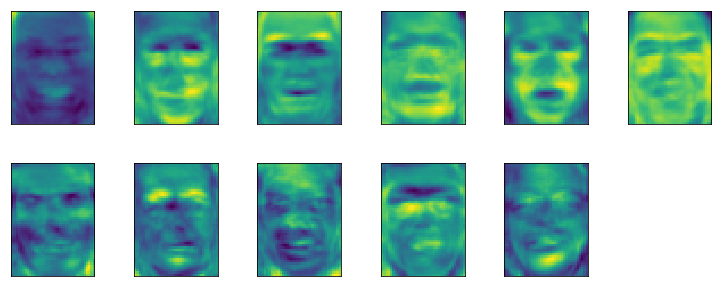

In [10]:
def plot_gallery(images, h, w, n_row=3, n_col=5, tot = 3*5):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(tot):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)))
        plt.xticks(())
        plt.yticks(())
        
plot_gallery(FF, h, w, n_row=11, n_col=6,tot = n_classes-1 )

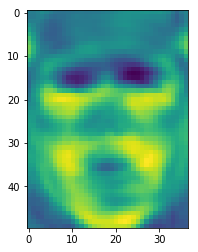

In [11]:
f = np.dot(pvec.T,np.dot(np.diag(np.power(pval,0.5)),np.dot(lXb[1000],lvec).T)).T
plt.imshow(f.reshape((h, w)))

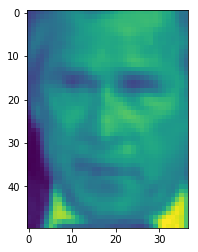

In [12]:
plt.imshow(X_train[1000].reshape((h, w)))

In [13]:
X_test_transformed = ldaTransform(lvec, pcaTransform(X_test,pvec,pval,pMean))
X_test_transformed.shape

(390, 11)

In [14]:
y_test = y_test.reshape((-1,1))
y_test.shape

(390, 1)

In [15]:
X_train_transformed = ldaTransform(lvec, pcaTransform(X_train,pvec,pval,pMean))
X_train_transformed.shape

(1170, 11)

In [16]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train_transformed, y_train.reshape(-1)) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=2,
           weights='uniform')

In [17]:
pre = neigh.predict(X_test_transformed)

In [18]:
neigh.score(X_test_transformed, y_test)

0.47435897435897434

In [19]:
print(classification_report(y_test, pre))

              precision    recall  f1-score   support

           0       0.44      0.32      0.37        22
           1       0.55      0.55      0.55        53
           2       0.14      0.15      0.14        27
           3       0.74      0.64      0.69       138
           4       0.28      0.35      0.31        26
           5       0.41      0.72      0.52        18
           6       0.27      0.30      0.29        10
           7       0.15      0.12      0.13        17
           8       0.29      0.36      0.32        11
           9       0.25      0.33      0.29        12
          10       0.57      0.38      0.46        21
          11       0.33      0.37      0.35        35

   micro avg       0.47      0.47      0.47       390
   macro avg       0.37      0.38      0.37       390
weighted avg       0.50      0.47      0.48       390



## Eigen Faces

In [20]:
ef_n = 12
efval, efvec, efXb, efMean = myPCA(X_train, ef_n)


In [21]:
Xef_test_transformed = pcaTransform(X_test,efvec,efval,efMean)

In [22]:
efXb.shape

(1170, 12)

In [23]:
Xef_test_transformed.shape

(390, 12)

In [24]:
neighef = KNeighborsClassifier(n_neighbors=10)
neighef.fit(efXb, y_train.reshape(-1)) 
print(neighef.score(Xef_test_transformed, y_test.reshape(-1)))
pre = neighef.predict(Xef_test_transformed)

print(classification_report(y_test, pre))

0.49743589743589745
              precision    recall  f1-score   support

           0       0.40      0.18      0.25        22
           1       0.37      0.72      0.49        53
           2       0.38      0.33      0.35        27
           3       0.62      0.75      0.68       138
           4       0.27      0.15      0.20        26
           5       0.50      0.28      0.36        18
           6       0.00      0.00      0.00        10
           7       0.62      0.29      0.40        17
           8       0.00      0.00      0.00        11
           9       0.25      0.17      0.20        12
          10       0.93      0.67      0.78        21
          11       0.31      0.26      0.28        35

   micro avg       0.50      0.50      0.50       390
   macro avg       0.39      0.32      0.33       390
weighted avg       0.47      0.50      0.47       390



/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## try SVM

In [26]:
print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_transformed, y_train.reshape(-1))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
pre = clf.predict(X_test_transformed)

print(classification_report(y_test, pre))

Fitting the classifier to the training set


/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        28
           3       0.00      0.00      0.00       118
           4       0.00      0.00      0.00        25
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        18
           7       0.00      0.00      0.00        18
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00        10
          11       0.09      1.00      0.17        37

   micro avg       0.09  

/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/nicwiggins/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
